In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/My Drive/Severstal-Steel-Defect-detection.zip'
with ZipFile(file_name,'r') as Zip:
  Zip.extractall()

In [1]:
import pandas as pd
import numpy as np
import cv2
import time
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sb
import os
import math
from random import random
import tensorflow as tf
import keras
from PIL import Image
from tensorflow.keras import backend as K
from keras.layers import Input, Lambda, Flatten,Conv2D,Dense,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,Activation,Add,UpSampling2D,Concatenate,LeakyReLU,Conv2DTranspose,concatenate
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
import tensorflow_addons as tfa
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Layer
from tensorflow.keras.applications import EfficientNetB0

%load_ext tensorboard

### IMPORTING CSV FILE

In [ ]:
df=pd.read_csv('train.csv')
print(df.shape)
df.head(2)

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...


#### FUNCTION FOR SOME TRANFORMATION LIKE RLE2MASK etc

In [ ]:
#https://stackoverflow.com/questions/58693261/create-a-rle-run-lenth-encoding-mask-with-tensorflow-datasets
def rle2mask(mask_rle):
  shape = tf.convert_to_tensor((1600,256), tf.int64)
  size = tf.math.reduce_prod(shape)
  s = tf.strings.split(mask_rle)
  s = tf.strings.to_number(s, tf.int64)
  starts = s[::2] - 1
  lens = s[1::2]
  total_ones = tf.reduce_sum(lens)
  ones = tf.ones([total_ones], tf.uint8)
  r = tf.range(total_ones)
  lens_cum = tf.math.cumsum(lens)
  s = tf.searchsorted(lens_cum, r, 'right')
  idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
  mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
  mask  = tf.transpose(tf.reshape(mask_flat, shape)[::2,::])
  return mask

### METRICS + LOSS

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true =  tf.cast(y_true,'float32')
    y_pred =  tf.cast(y_pred,'float32')
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)    

### MODEL ARCHITECTURE

In [ ]:
def decoder(filter,X,layer_name,skip=True):
        x = UpSampling2D((2, 2))(X)
        if skip==True:
          x_skip = encoder.get_layer(layer_name).output
          x = Concatenate()([x, x_skip])
        
        x = Conv2D(filter, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x= Dropout(0.25)(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filter, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x= Dropout(0.15)(x)
        x = Activation('relu')(x)
        return x

In [ ]:
inputs = Input(shape=(256, 800, 3))
encoder = EfficientNetB0(input_tensor=inputs, weights="imagenet", include_top=False)

x=decoder(256,encoder.output,'block6a_expand_activation',skip=True)# filter size, prvious layer intput, concat layer name, skip=True
x=decoder(128,x,'block4a_expand_activation',skip=True)
x=decoder(64,x,'block3a_expand_activation',skip=True)
x=decoder(32,x,'block2a_expand_activation',skip=True)
x=decoder(16,x,'None',skip=False)

x=Conv2D(1,3,padding='same')(x)
out=Activation('sigmoid')(x)


16711680/16705208 [==============================] - 1s 0us/step


In [ ]:
model=Model(inputs=inputs,outputs=out)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 800, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 800, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 800, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 801, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

### TF.DATA

###### AUGMENTATION

In [ ]:
def augment(image, mask):
    a=random()
    if a>0.2 and a<0.3:
      image = tf.image.random_flip_left_right(image)
      image = tf.clip_by_value(image, 0.0, 1.0)

      mask = tf.image.random_flip_left_right(mask)
      mask = tf.clip_by_value(image, 0.0, 1.0)
      return image, mask
    
  
    if a>0.45 and a<0.6:
      image=tf.image.random_flip_up_down(image)
      image = tf.clip_by_value(image, 0.0, 1.0)

      mask=tf.image.random_flip_up_down(mask)
      mask = tf.clip_by_value(mask, 0.0, 1.0)
      return image, mask
    if a>0.65 and a<0.75:
      image=tf.image.random_contrast(image,0.6,1.4)
      image = tf.clip_by_value(image, 0.0, 1.0)

      mask=tf.image.random_contrast(mask,0.6,1.4)
      mask = tf.clip_by_value(mask, 0.0, 1.0)
      return image, mask
      
    else:
      image = tf.clip_by_value(image, 0.0, 1.0)
      return image, mask      

In [ ]:
def preprocess_image(filename,mask_file):
    #image preprocessing
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float16)
    image = tf.image.resize(image, [256,800])
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    #mask preprocessing
    mask=rle2mask(mask_file)
    mask=tf.expand_dims(mask,2)
    return image, mask

###### TRAIN

In [ ]:
def tfdata_train(filenames,mask_file,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((filenames,mask_file))
  dataset= dataset.shuffle(len(filenames))
  #convert file path name to image array and ask array
  dataset= dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #augmentaion
  dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
  return dataset

###### VAL

In [ ]:
def tfdata_test(filenames,mask_file,batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((filenames,mask_file))
  dataset = dataset.shuffle(len(filenames))
  dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset=dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

###### TEST

In [ ]:
def tf_test(filenames,mask_file):
  dataset = tf.data.Dataset.from_tensor_slices((filenames, mask_file))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(1)
  return dataset

### FUNCTION FOR TRAINGING DATA

In [ ]:
def training(X_train_seg,X_val_seg,bs,epoch,path,train_steps,validation_steps):
  #loading model
  model=Model(inputs=inputs,outputs=out)
  #batch size
  BATCH_SIZE=bs
  iters = math.ceil(100/BATCH_SIZE) 
  #epoch
  EPOCHS=epoch
  #train step function
  @tf.function
  def train_step(input_vector, output_vector):
      with tf.GradientTape() as tape:
          #forward propagation
          output_predicted = model(inputs=input_vector, training=True)
          #loss
          loss = dice_loss(output_vector, output_predicted)
      #getting gradients
      gradients = tape.gradient(loss, model.trainable_variables)
      #applying gradients
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      return loss, output_predicted, gradients

  ##validation step function
  @tf.function
  def val_step(input_vector, output_vector):
      #getting output of validation data
      output_predicted = model(inputs=input_vector, training=False)
      #loss calculation
      loss = dice_loss(output_vector, output_predicted)
      return loss, output_predicted

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  val_loss = tf.keras.metrics.Mean(name='val_loss')
  train_metric = tf.keras.metrics.Mean(name="train_dice_coff ")
  val_metric = tf.keras.metrics.Mean(name="val_metric")

  #path='/content/drive/My Drive/defect1_seg_model/'
  wtrain = tf.summary.create_file_writer(logdir=path+'logs/train')
  wval = tf.summary.create_file_writer(logdir=path+'logs/val')
  
  
  for epoch in range(EPOCHS):
      
      #resetting the states of the loss and metrics
      train_loss.reset_states()
      val_loss.reset_states()
      train_metric.reset_states()
      val_metric.reset_states()
      
      ##counter for train loop iteration
      counter = 0
      
      #lists to save true and validation data. 
      train_true = []
      train_predicted = []
      val_true = []
      val_predicted = []

      #ietrating over train data batch by batch
      for image,mask in X_train_seg:
          #train step
          loss_, pred_out, gradients = train_step(image, mask)
          #adding loss to train loss
          train_loss(loss_)
          #counting the step number
          temp_step = epoch*iters+counter
          counter = counter + 1
          
          #calculating dice coff  for batch
          batch_metric = dice_coef(mask, pred_out)
          train_metric(batch_metric)
          
          #appending it to list
          train_predicted.append(pred_out)
          train_true.append(mask)
          
          ##tensorboard 
          with tf.name_scope('per_step_training'):
              with wtrain.as_default():
                  tf.summary.scalar("batch_loss", loss_, step=temp_step)
                  tf.summary.scalar('batch_metric', batch_metric, step=temp_step)
          with tf.name_scope("per_batch_gradients"):
              with wtrain.as_default():
                  for i in range(len(model.trainable_variables)):
                      name_temp = model.trainable_variables[i].name
                      tf.summary.histogram(name_temp, gradients[i], step=temp_step)
          if counter%train_steps==0 and counter!=0:
            break

      #saving model    
      filename=path+'weights_'+str(epoch)+'.hdf5'
      tf.saved_model.save(model, filename)

      #calculating the final loss and metric
      train_true = tf.concat(train_true, axis=0)
      train_predicted = tf.concat(train_predicted, axis=0)
      train_loss_final = dice_loss(train_true, train_predicted)
      train_metric_dice_coef = dice_coef(train_true, train_predicted)
    
      counter = 0
      for image_val,mask_val in X_val_seg:
          loss_val, pred_out_val = val_step(image_val, mask_val)
          #appending to lists
          val_true.append(mask_val)
          val_predicted.append(pred_out_val)
          val_loss(loss_val)
          #calculating metric
          batch_metric_val = dice_coef(mask_val, pred_out_val)
          val_metric(batch_metric_val)
          #validation_steps
          counter = counter + 1
          if counter%validation_steps==0 and counter!=0:
            break
          
      
      
      #calculating final loss and metric   
      val_true = tf.concat(val_true, axis=0)
      val_predicted = tf.concat(val_predicted, axis=0)
      val_loss_final = dice_loss(val_true, val_predicted)
      val_metric_dice_coef = dice_coef(val_true, val_predicted)
      
      #printing loss and metrics valve
      template = '''Epoch {}, Train Loss: {:0.6f}, Mean batch Train Loss: {:0.6f}, dice coef: {:0.5f}, Mean batch Train dice coff: {:0.5f},
      Val Loss: {:0.6f}, Mean batch Val Loss: {:0.6f}, Val dice coef: {:0.5f}, Mean batch Val dice coef: {:0.5f}'''
      
      print(template.format(epoch+1, train_loss_final.numpy(), train_loss.result(), 
                            train_metric_dice_coef, train_metric.result(), val_loss_final.numpy(),
                            val_loss.result(), val_metric_dice_coef, val_metric.result()))
      print('-'*30)
      
      #tensorboard
      with tf.name_scope("per_epoch_loss_metric"):
          with wtrain.as_default():
              tf.summary.scalar("mean_loss", train_loss.result().numpy(), step=epoch)
              tf.summary.scalar('loss', train_loss_final.numpy(), step=epoch)
              tf.summary.scalar('metric', train_metric_dice_coef, step=epoch)
              tf.summary.scalar('mean_metric', train_metric.result().numpy(), step=epoch)
          with wval.as_default():
              tf.summary.scalar('mean_loss', val_loss.result().numpy(), step=epoch)
              tf.summary.scalar('loss', val_loss_final.numpy(), step=epoch)
              tf.summary.scalar('metric', val_metric_dice_coef, step=epoch)
              tf.summary.scalar('mean_metric', val_metric.result().numpy(), step=epoch)

### IMAGE VISUALISATION 

In [ ]:
def visual_image(model):
  for j in test.take(6):
      #orginal steel image
      image=j[0][0]
      #orginal mask
      mask=j[1][0,:,:,0]
      #predict mask
      predict=model.predict(j[0])[0,:,:,0]

      
      plt.figure(figsize=(12,8))
      plt.subplot(131)
      plt.imshow(image)
      plt.subplot(132)
      plt.imshow(mask)
      plt.subplot(133)
      plt.imshow(predict)
      plt.show()

## DEFECT 1

In [ ]:
seg_type_1_data=df[df.ClassId==1]

In [ ]:
seg_type_1_data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
18,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
21,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...


In [ ]:
seg_type_1_data['ImageId']=['train_images/'+i for i in seg_type_1_data.ImageId]
seg_type_1_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ImageId,ClassId,EncodedPixels
0,train_images/0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,train_images/000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,train_images/002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
18,train_images/008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
21,train_images/00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...


In [ ]:
X_train, X_test = train_test_split(seg_type_1_data, test_size = 0.15,random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.16,random_state=42)
print('train shape : ',X_train.shape)
print('test shape : ', X_test.shape)
print('val shape : ', X_val.shape)

train shape :  (640, 3)
test shape :  (135, 3)
val shape :  (122, 3)


In [ ]:
X_train.head()

,ImageId,ClassId,EncodedPixels
4868,train_images/b07380a2e.jpg,1,374501 3 374753 11 375005 18 375257 25 375509 ...
4534,train_images/a56c8f958.jpg,1,41660 45 41827 134 42033 184 42283 190 42539 1...
5646,train_images/cb7c34c05.jpg,1,67509 3 67761 7 68012 12 68264 16 68515 20 687...
1699,train_images/3ecff5d55.jpg,1,375212 8 375243 2 375383 5 375466 13 375498 7 ...
418,train_images/0f010cc60.jpg,1,46349 3 46605 8 46861 12 47118 16 47374 21 476...


In [ ]:
X_train_seg_1=tfdata_train(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist(),8)
X_val_seg_1=tfdata_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist(),8)
X_train_seg_1,X_val_seg_1

(<PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>)

In [2]:
path='/content/drive/My Drive/defect1_seg_model/'
training(X_train_seg_1,X_val_seg_1,16,10,path)

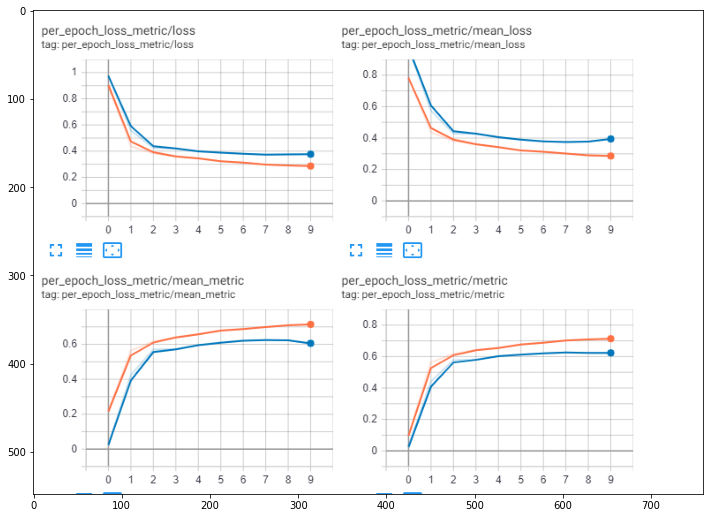

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread('/content/drive/My Drive/Image_CS@2/seg_1.png'))

In [3]:
%tensorboard --logdir /content/drive/My\ Drive/defect1_seg_model/

###### TESTING MODEL

In [ ]:
po='/content/drive/My Drive/defect1_seg_model/weights_7.hdf5'
model1=tensorflow.keras.models.load_model(filepath=po)

In [ ]:
model1.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])

In [ ]:
test=tf_test(X_test.ImageId.tolist(),X_test.EncodedPixels.tolist())
train=tf_test(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist())
val=tf_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist())

In [ ]:
pd.DataFrame(np.array(model1.evaluate(test)).reshape(1,-1),columns=['test_loss','test_dice_coef'])

135/135 [==============================] - 7s 53ms/step - loss: 0.3815 - dice_coef: 0.6185


,test_loss,test_dice_coef
0,0.381537,0.618463


In [ ]:
pd.DataFrame(np.array(model1.evaluate(val)).reshape(1,-1),columns=['val_loss','val_dice_coef'])

122/122 [==============================] - 6s 53ms/step - loss: 0.3898 - dice_coef: 0.6102


,val_loss,val_dice_coef
0,0.389764,0.610236


In [ ]:
pd.DataFrame(np.array(model1.evaluate(train)).reshape(1,-1),columns=['train_loss','train_dice_coef'])

640/640 [==============================] - 34s 53ms/step - loss: 0.2790 - dice_coef: 0.7210


,train_loss,train_dice_coef
0,0.279047,0.720953


##### VISUALISATION OF PREDICT MASK

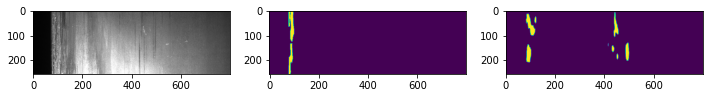

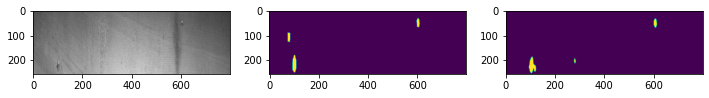

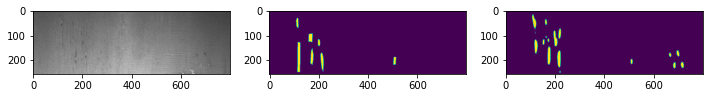

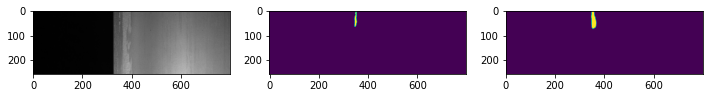

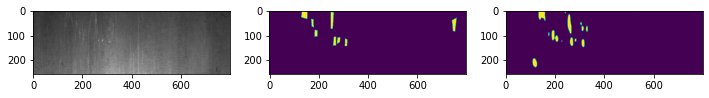

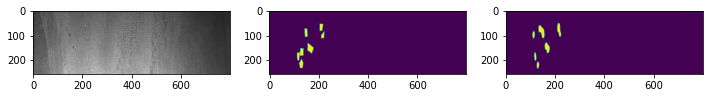

In [ ]:
visual_image(model1)

# DEFECT 2

In [ ]:
seg_type_2_data=df[df.ClassId==2]

In [ ]:
seg_type_2_data['ImageId']=['train_images/'+i for i in seg_type_2_data.ImageId]
seg_type_2_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ImageId,ClassId,EncodedPixels
9,train_images/002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...
19,train_images/008ef3d74.jpg,2,375439 5 375687 14 375935 24 376182 34 376430 ...
22,train_images/00ac8372f.jpg,2,98114 24 98370 72 98626 119 98881 168 99137 19...
27,train_images/00c88fed0.jpg,2,13428 8 13684 24 13940 39 14196 55 14452 71 14...
75,train_images/026183d85.jpg,2,120132 16 120388 46 120643 78 120899 108 12115...


In [ ]:
X_train, X_test = train_test_split(seg_type_2_data, test_size = 0.18,random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.20,random_state=42)
print('train shape : ',X_train.shape)
print('test shape : ', X_test.shape)
print('val shape : ', X_val.shape)

train shape :  (161, 3)
test shape :  (45, 3)
val shape :  (41, 3)


In [ ]:
X_train.head()

,ImageId,ClassId,EncodedPixels
2667,train_images/62bf70fee.jpg,2,376764 8 377004 24 377244 40 377484 56 377725 ...
1605,train_images/3ad134b40.jpg,2,90103 10 90340 29 90577 48 90815 66 91052 85 9...
5767,train_images/cef5ff47d.jpg,2,248133 10 248389 29 248645 48 248901 67 249157...
3045,train_images/6fcd94e33.jpg,2,380599 2 380853 8 381107 14 381362 18 381429 1...
3052,train_images/6fdf2d1be.jpg,2,233985 46 234241 136 234497 181 234753 181 235...


In [ ]:
X_train_seg_2=tfdata_train(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist(),8)
X_val_seg_2=tfdata_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist(),8)
X_train_seg_2,X_val_seg_2

(<PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>)

In [ ]:
path='/content/drive/My Drive/defect2_seg_model/'
training(X_train_seg_2,X_val_seg_2,8,8,path,20,5)

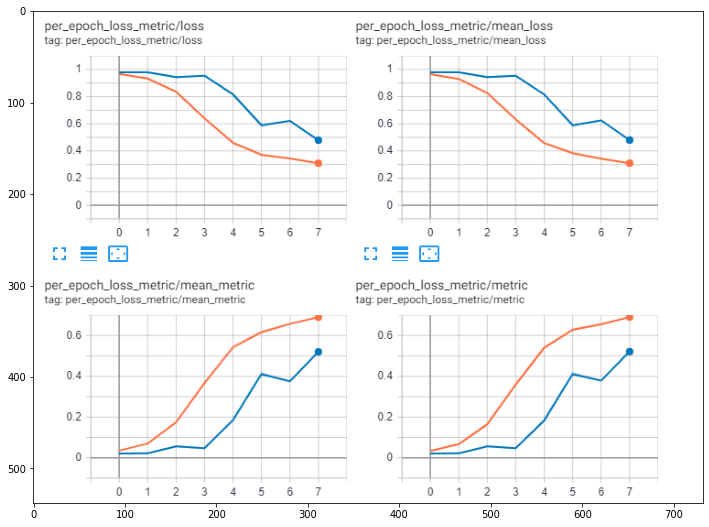

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread('/content/drive/My Drive/Image_CS@2/seg_2.png'))

In [4]:
%tensorboard --logdir /content/drive/My\ Drive/defect2_seg_model/

###### TESTING MODEL

In [ ]:
po='/content/drive/My Drive/defect2_seg_model/weights_7.hdf5'
model2=tensorflow.keras.models.load_model(filepath=po)

In [ ]:
model2.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])

In [ ]:
test=tf_test(X_test.ImageId.tolist(),X_test.EncodedPixels.tolist())
train=tf_test(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist())
val=tf_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist())

In [ ]:
pd.DataFrame(np.array(model2.evaluate(test)).reshape(1,-1),columns=['test_loss','test_dice_coef'])

45/45 [==============================] - 2s 54ms/step - loss: 0.4571 - dice_coef: 0.5429


,test_loss,test_dice_coef
0,0.457115,0.542885


In [ ]:
pd.DataFrame(np.array(model2.evaluate(val)).reshape(1,-1),columns=['val_loss','val_dice_coef'])

41/41 [==============================] - 2s 52ms/step - loss: 0.4978 - dice_coef: 0.5022


,val_loss,val_dice_coef
0,0.497813,0.502187


In [ ]:
pd.DataFrame(np.array(model2.evaluate(train)).reshape(1,-1),columns=['train_loss','train_dice_coef'])

161/161 [==============================] - 8s 53ms/step - loss: 0.4612 - dice_coef: 0.5388


,train_loss,train_dice_coef
0,0.461177,0.538823


##### VISUALISATION OF PREDICT MASK

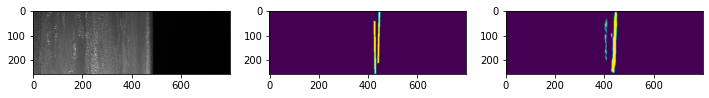

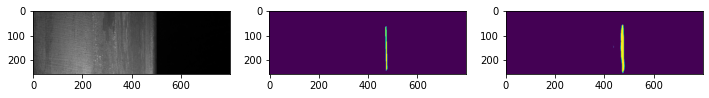

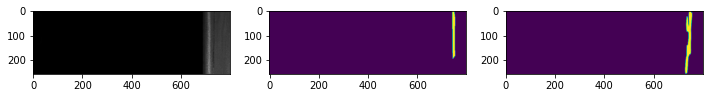

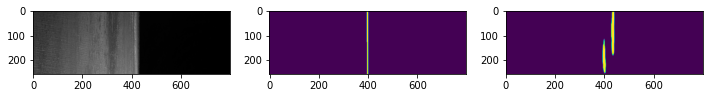

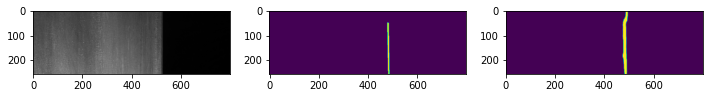

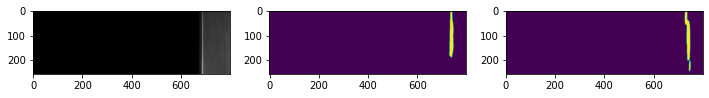

In [ ]:
visual_image(model2)

# DEFECT 3

In [ ]:
seg_type_3_data=df[df.ClassId==3]

In [ ]:
seg_type_3_data['ImageId']=['train_images/'+i for i in seg_type_3_data.ImageId]
seg_type_3_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ImageId,ClassId,EncodedPixels
1,train_images/0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
4,train_images/0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,train_images/0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
11,train_images/0046839bd.jpg,3,152926 1 153180 4 153434 6 153689 8 153943 11 ...
12,train_images/005d86c25.jpg,3,331 18 587 53 843 89 1099 124 1355 159 1611 17...


In [ ]:
X_train, X_test = train_test_split(seg_type_3_data, test_size = 0.2,random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.24,random_state=42)
print('train shape : ',X_train.shape)
print('test shape : ', X_test.shape)
print('val shape : ', X_val.shape)

train shape :  (3131, 3)
test shape :  (1030, 3)
val shape :  (989, 3)


In [ ]:
X_train.head()

,ImageId,ClassId,EncodedPixels
3199,train_images/74abdf1ef.jpg,3,52715 22 52929 64 53143 106 53357 148 53571 19...
2035,train_images/4b925c919.jpg,3,5437 6 5692 19 5947 32 6202 44 6457 57 6712 70...
770,train_images/1c61eaea9.jpg,3,103167 1 103421 3 103675 5 103930 6 104184 8 1...
6153,train_images/dd175c50c.jpg,3,194545 2 194799 4 195054 4 195309 5 195564 6 1...
2228,train_images/5283b3138.jpg,3,206616 11 206871 13 207127 14 207382 16 207637...


In [ ]:
X_train_seg_3=tfdata_train(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist(),6)
X_val_seg_3=tfdata_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist(),6)
X_train_seg_3,X_val_seg_3

(<PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>)

In [5]:
path='/content/drive/My Drive/defect3_seg_model/'
training(X_train_seg_3,X_val_seg_3,6,14,path,240,75)

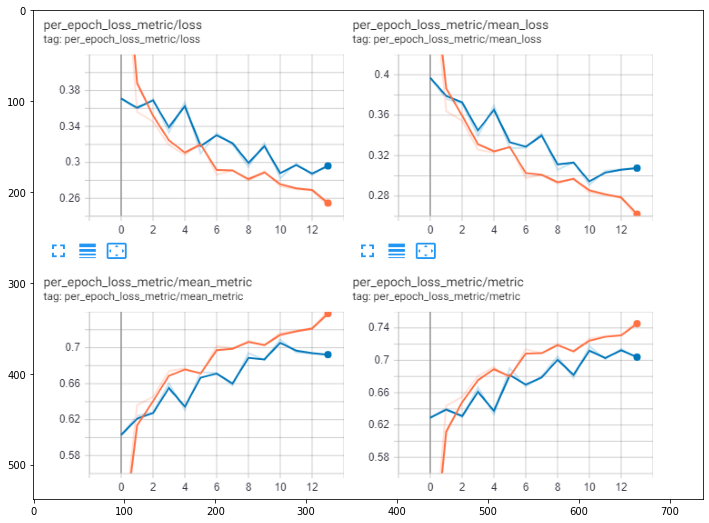

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread('/content/drive/My Drive/Image_CS@2/seg_3.png'))

In [6]:
%tensorboard --logdir /content/drive/My\ Drive/defect3_seg_model/

###### TESTING MODEL

In [ ]:
po='/content/drive/My Drive/defect3_seg_model/weights_10.hdf5'
model3=tensorflow.keras.models.load_model(filepath=po)

In [ ]:
model3.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])

In [ ]:
test=tf_test(X_test.ImageId.tolist(),X_test.EncodedPixels.tolist())
train=tf_test(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist())
val=tf_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist())

In [ ]:
pd.DataFrame(np.array(model3.evaluate(test)).reshape(1,-1),columns=['test_loss','test_dice_coef'])

1030/1030 [==============================] - 54s 53ms/step - loss: 0.3200 - dice_coef: 0.6800


,test_loss,test_dice_coef
0,0.320037,0.679962


In [ ]:
pd.DataFrame(np.array(model3.evaluate(val)).reshape(1,-1),columns=['val_loss','val_dice_coef'])

989/989 [==============================] - 52s 53ms/step - loss: 0.3257 - dice_coef: 0.6743


,val_loss,val_dice_coef
0,0.325744,0.674256


In [ ]:
pd.DataFrame(np.array(model3.evaluate(train)).reshape(1,-1),columns=['train_loss','train_dice_coef'])

3131/3131 [==============================] - 165s 53ms/step - loss: 0.3084 - dice_coef: 0.6916


,train_loss,train_dice_coef
0,0.308404,0.691597


##### VISUALISATION OF PREDICT MASK

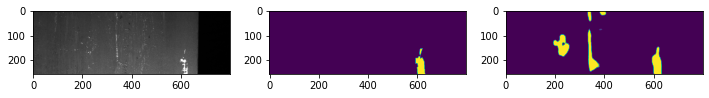

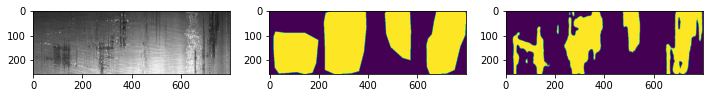

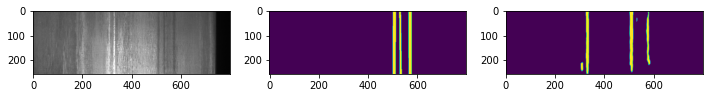

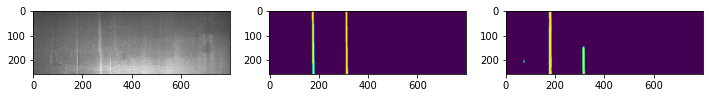

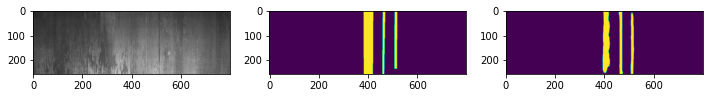

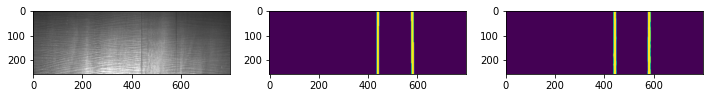

In [ ]:
visual_image(model3)

# DEFECT 4

In [ ]:
seg_type_4_data=df[df.ClassId==4]

In [ ]:
seg_type_4_data['ImageId']=['train_images/'+i for i in seg_type_4_data.ImageId]
seg_type_4_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ImageId,ClassId,EncodedPixels
3,train_images/000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
6,train_images/0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
7,train_images/002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
10,train_images/0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
15,train_images/008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...


In [ ]:
X_train, X_test = train_test_split(seg_type_4_data, test_size = 0.16,random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.17,random_state=42)
print('train shape : ',X_train.shape)
print('test shape : ', X_test.shape)
print('val shape : ',X_val.shape)

train shape :  (557, 3)
test shape :  (129, 3)
val shape :  (115, 3)


In [ ]:
X_train.head()

,ImageId,ClassId,EncodedPixels
3040,train_images/6fa9e1d65.jpg,4,262744 5 262999 9 263252 14 263502 22 263752 3...
916,train_images/20edbd1a8.jpg,4,105271 2 105527 5 105783 8 106038 13 106294 16...
2466,train_images/5b5543800.jpg,4,251401 7 251657 9 251914 10 252170 12 252426 1...
6819,train_images/f60b4d359.jpg,4,56324 2 56580 4 56836 6 57092 8 57348 10 57603...
62,train_images/01cfacf80.jpg,4,10 82 139 18 265 149 521 150 776 152 1032 152 ...


In [ ]:
X_train_seg_4=tfdata_train(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist(),8)
X_val_seg_4=tfdata_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist(),8)
X_train_seg_4,X_val_seg_4

(<PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 256, 800, 3), (None, 256, 800, 1)), types: (tf.uint8, tf.uint8)>)

In [7]:
path='/content/drive/My Drive/defect4_seg_model/'
training(X_train_seg_4,X_val_seg_4,8,10,path,60,15)

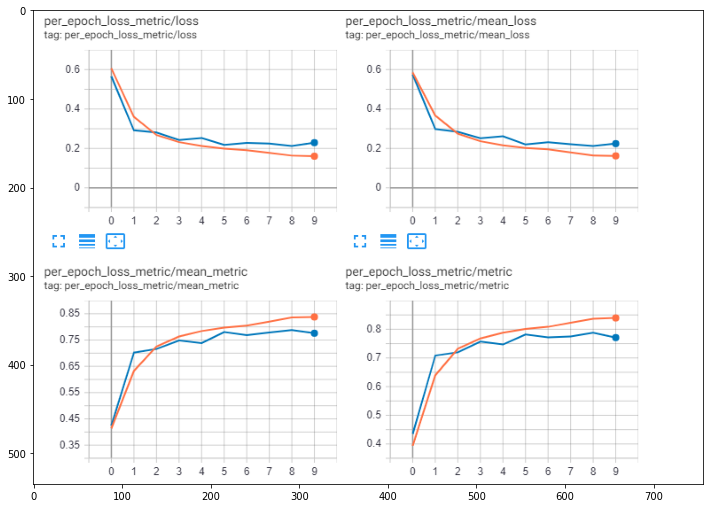

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(plt.imread('/content/drive/My Drive/Image_CS@2/seg_4.png'))

In [8]:
%tensorboard --logdir /content/drive/My\ Drive/defect4_seg_model/

###### TESTING MODEL

In [ ]:
po='/content/drive/My Drive/defect4_seg_model/weights_8.hdf5'
model4=tensorflow.keras.models.load_model(filepath=po)

In [ ]:
model4.compile(optimizer='adam',loss=dice_loss,metrics=[dice_coef])

In [ ]:
test=tf_test(X_test.ImageId.tolist(),X_test.EncodedPixels.tolist())
train=tf_test(X_train.ImageId.tolist(),X_train.EncodedPixels.tolist())
val=tf_test(X_val.ImageId.tolist(),X_val.EncodedPixels.tolist())

In [ ]:
pd.DataFrame(np.array(model4.evaluate(test)).reshape(1,-1),columns=['test_loss','test_dice_coef'])

129/129 [==============================] - 7s 54ms/step - loss: 0.2357 - dice_coef: 0.7643


,test_loss,test_dice_coef
0,0.235719,0.764281


In [ ]:
pd.DataFrame(np.array(model4.evaluate(val)).reshape(1,-1),columns=['val_loss','val_dice_coef'])

115/115 [==============================] - 6s 55ms/step - loss: 0.2313 - dice_coef: 0.7687


,val_loss,val_dice_coef
0,0.231341,0.768659


In [ ]:
pd.DataFrame(np.array(model4.evaluate(train)).reshape(1,-1),columns=['train_loss','train_dice_coef'])

557/557 [==============================] - 30s 53ms/step - loss: 0.1743 - dice_coef: 0.8257


,train_loss,train_dice_coef
0,0.174342,0.825658


##### VISUALISATION OF PREDICT MASK

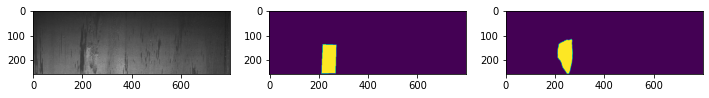

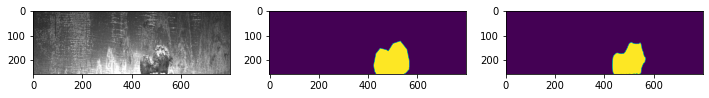

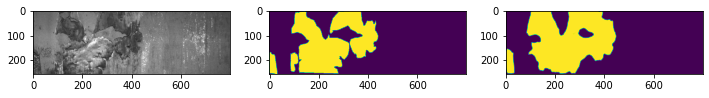

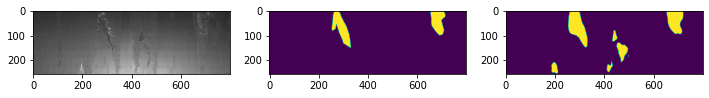

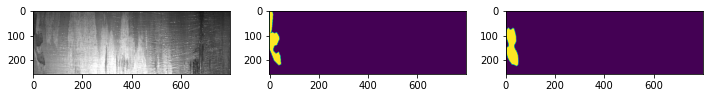

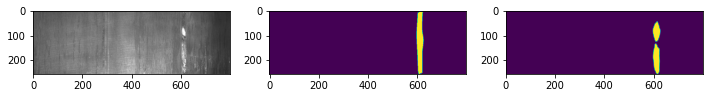

In [ ]:
visual_image(model4)